# Project 1: Linear Regression

## Import module

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn import linear_model
from scipy import stats as ss
import seaborn as sns
from pygam import LinearGAM, s, l
import xgboost

## I. ĐỌC DỮ LIỆU (READ DATA)

In [2]:
# Đọc dữ liệu từ file
dataX = pd.read_csv("X_train.csv")
dataY = pd.read_csv("Y_train.csv")
dataX.drop(['id'], axis=1, inplace=True, errors='ignore')
dataY.drop(['id'], axis=1, inplace=True, errors='ignore')

# Sao chép dữ liệu vào 2 dataframe khác để chạy mô hình baseline
baselineX = dataX.copy()
baselineY = dataY.copy()

# Tạo dataframe có cả features và outcome
data = dataX.copy()
data.insert(22, "price", dataY['price'], True) 
data.head(5)

,manufacturer,model,transmission,color,odometer,year,engineFuel,engineType,engineCapacity,bodyType,...,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,price
0,Hyundai,i40,automatic,red,48000,2014,gasoline,gasoline,2.0,sedan,...,True,False,False,False,True,False,False,True,True,15500.0
1,Mitsubishi,Carisma,mechanical,green,320000,2000,diesel,diesel,1.9,hatchback,...,True,False,False,False,False,False,False,False,False,2800.0
2,Volkswagen,T5,mechanical,white,164000,2011,diesel,diesel,2.0,minibus,...,True,False,True,False,False,True,True,True,False,16700.0
3,Volkswagen,T4 Multivan,mechanical,blue,385672,1998,diesel,diesel,2.5,minibus,...,True,True,False,False,False,False,False,True,True,11000.0
4,Toyota,Camry,automatic,black,215652,2005,gasoline,gasoline,2.4,sedan,...,False,False,False,False,False,False,False,False,True,6800.0


## II. TỔNG QUAN VỀ DỮ LIỆU (DATA OVERVIEW)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   manufacturer    30000 non-null  object 
 1   model           30000 non-null  object 
 2   transmission    30000 non-null  object 
 3   color           30000 non-null  object 
 4   odometer        30000 non-null  int64  
 5   year            30000 non-null  int64  
 6   engineFuel      30000 non-null  object 
 7   engineType      30000 non-null  object 
 8   engineCapacity  29991 non-null  float64
 9   bodyType        30000 non-null  object 
 10  drivetrain      30000 non-null  object 
 11  photos          30000 non-null  int64  
 12  feature_0       30000 non-null  bool   
 13  feature_1       30000 non-null  bool   
 14  feature_2       30000 non-null  bool   
 15  feature_3       30000 non-null  bool   
 16  feature_4       30000 non-null  bool   
 17  feature_5       30000 non-null 

- Dữ liệu gồm 30000 dòng với 22 thuộc tính .
- Lưu ý thuộc tính ‘engineCapacity’ có 29991 dòng non-null ⇒ có 9 dòng không có giá trị ‘engineCapcity'.

In [4]:
data.describe(include=[np.number])  

,odometer,year,engineCapacity,photos,price
count,30000.000000,30000.000000,29991.000000,30000.000000,30000.000000
mean,252853.225500,2003.127633,2.054022,9.702933,6599.796028
std,131396.318447,7.515763,0.662445,6.129236,6096.244533
min,1.000000,1960.000000,0.200000,1.000000,1.000000
25%,163000.000000,1998.000000,1.600000,5.000000,2300.000000
50%,250000.000000,2003.000000,2.000000,8.000000,4900.000000
75%,326412.500000,2009.000000,2.300000,12.000000,8999.000000
max,1000000.000000,2019.000000,7.500000,86.000000,50000.000000


In [5]:
data.describe(include=[np.object])  

,manufacturer,model,transmission,color,engineFuel,engineType,bodyType,drivetrain
count,30000,30000,30000,30000,30000,30000,30000,30000
unique,50,992,2,12,5,3,12,3
top,Volkswagen,Passat,mechanical,black,gasoline,gasoline,sedan,front
freq,3425,1141,19929,6116,19081,19279,9897,21935


In [6]:
data.describe(include=[np.bool])  

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9
count,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000
unique,2,2,2,2,2,2,2,2,2,2
top,False,True,False,False,False,False,False,False,False,True
freq,23765,18894,23059,21449,22586,18995,24682,21790,17013,17867


## III. LÀM SẠCH DỮ LIỆU (DATA CLEANING)

### 1. Giá trị của các categorical feature

In [7]:
data.dtypes

manufacturer       object
model              object
transmission       object
color              object
odometer            int64
year                int64
engineFuel         object
engineType         object
engineCapacity    float64
bodyType           object
drivetrain         object
photos              int64
feature_0            bool
feature_1            bool
feature_2            bool
feature_3            bool
feature_4            bool
feature_5            bool
feature_6            bool
feature_7            bool
feature_8            bool
feature_9            bool
price             float64
dtype: object

In [8]:
dataX.select_dtypes(['object']).columns

Index(['manufacturer', 'model', 'transmission', 'color', 'engineFuel',
       'engineType', 'bodyType', 'drivetrain'],
      dtype='object')

In [9]:
pd.DataFrame(np.sort(dataX.manufacturer.unique()), columns=['manufacturer'])
print('manufacturer:\n', np.sort(dataX.manufacturer.unique()))

manufacturer:
 ['Acura' 'Alfa Romeo' 'Audi' 'BMW' 'Buick' 'Cadillac' 'Chery' 'Chevrolet'
 'Chrysler' 'Citroen' 'Dacia' 'Daewoo' 'Dodge' 'Fiat' 'Ford' 'Geely'
 'Great Wall' 'Honda' 'Hyundai' 'Infiniti' 'Iveco' 'Jaguar' 'Jeep' 'Kia'
 'LADA' 'Lancia' 'Land Rover' 'Lexus' 'Lifan' 'Lincoln' 'Mazda'
 'Mercedes-Benz' 'Mini' 'Mitsubishi' 'Nissan' 'Opel' 'Peugeot' 'Pontiac'
 'Porsche' 'Renault' 'Rover' 'Saab' 'Seat' 'Skoda' 'SsangYong' 'Subaru'
 'Suzuki' 'Toyota' 'Volkswagen' 'Volvo']


In [10]:
pd.DataFrame(np.sort(dataX.model.unique()), columns=['model'])

,model
0,100
1,1007
2,100NX
3,106
4,107
...,...
987,i30
988,i40
989,ix20
990,ix35


In [11]:
pd.DataFrame(np.sort(dataX.transmission.unique()), columns=['transmission'])

,transmission
0,automatic
1,mechanical


In [12]:
pd.DataFrame(np.sort(dataX.color.unique()), columns=['color'])

,color
0,black
1,blue
2,brown
3,green
4,grey
5,orange
6,other
7,red
8,silver
9,violet


In [13]:
pd.DataFrame(np.sort(dataX.engineFuel.unique()), columns=['engineFuel'])

,engineFuel
0,diesel
1,electric
2,gasoline
3,hybrid-diesel
4,hybrid-petrol


In [14]:
pd.DataFrame(np.sort(dataX.engineType.unique()), columns=['engineType'])

,engineType
0,diesel
1,electric
2,gasoline


In [15]:
pd.DataFrame(np.sort(dataX.bodyType.unique()), columns=['bodyType'])

,bodyType
0,cabriolet
1,coupe
2,hatchback
3,liftback
4,limousine
5,minibus
6,minivan
7,pickup
8,sedan
9,suv


In [16]:
pd.DataFrame(np.sort(dataX.drivetrain.unique()), columns=['drivetrain'])

,drivetrain
0,all
1,front
2,rear


- Giá trị của các categorical feature đã chuẩn sẵn.

### 2. Dữ liệu nhiễu (Missing values)

In [17]:
# Phát hiện dữ liệu nhiễu
NaNRows = data[data.isna().any(axis=1)]
NaNRows

,manufacturer,model,transmission,color,odometer,year,engineFuel,engineType,engineCapacity,bodyType,...,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,price
2371,Nissan,Leaf,automatic,white,50000,2014,electric,electric,NaN,hatchback,...,True,False,False,False,True,False,True,True,False,12900.0
3431,BMW,i3,automatic,white,54150,2015,electric,electric,NaN,hatchback,...,True,True,True,False,True,True,True,True,True,24750.0
12191,Fiat,500,automatic,orange,27000,2013,electric,electric,NaN,hatchback,...,True,False,True,True,True,False,True,True,True,14900.0
13169,Chevrolet,Volt,automatic,silver,168000,2013,electric,electric,NaN,liftback,...,False,False,True,False,False,False,True,True,True,12950.0
14863,Nissan,Leaf,automatic,black,84500,2013,electric,electric,NaN,hatchback,...,True,False,True,False,True,True,True,True,True,15500.0
15094,Fiat,500,automatic,orange,49000,2014,electric,electric,NaN,hatchback,...,False,False,True,False,True,False,True,False,True,16000.0
26476,Nissan,Leaf,automatic,white,57357,2015,electric,electric,NaN,hatchback,...,True,True,True,True,True,True,True,True,True,13850.0
27818,BMW,i3,automatic,other,67000,2018,electric,electric,NaN,liftback,...,True,True,True,True,True,True,True,True,True,39999.0
29854,Nissan,Leaf,automatic,blue,97400,2011,electric,electric,NaN,hatchback,...,True,False,False,False,False,False,True,False,True,9300.0


- Dữ liễu nhiễu là 9 dòng có giá trị cột ‘engineCapacity’ bị bỏ trống.

In [18]:
# Xử lý dữ liệu nhiễu 
dataX.drop(index=NaNRows.index, errors='ignore', inplace=True)
dataY.drop(index=NaNRows.index, errors='ignore', inplace=True)
data.drop(index=NaNRows.index, errors='ignore', inplace=True)

- Áp dụng cách xử lí loại bỏ các dòng dữ liệu nhiễu. 
- Dữ liệu còn lại gồm 29991 dòng.

### 3. Dữ liệu lặp (Duplicate records)

In [19]:
# Phát hiện dữ liệu lặp 
# Các dòng dữ liệu có các giá trị thuộc tính bị lặp lại:
duplicateRows = dataX[dataX.duplicated(keep=False)]
index1=duplicateRows.index
data.loc[duplicateRows.index.tolist()].sort_values(by=['manufacturer', 'model'])

,manufacturer,model,transmission,color,odometer,year,engineFuel,engineType,engineCapacity,bodyType,...,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,price
4758,Audi,80,mechanical,black,350000,1991,gasoline,gasoline,1.8,sedan,...,False,False,False,False,False,False,False,False,False,1750.0
22010,Audi,80,mechanical,black,350000,1991,gasoline,gasoline,1.8,sedan,...,False,False,False,False,False,False,False,False,False,1450.0
10146,Audi,A4,mechanical,blue,325000,2002,diesel,diesel,2.5,universal,...,False,False,False,False,False,False,False,False,False,5650.0
14584,Audi,A4,mechanical,blue,325000,2002,diesel,diesel,2.5,universal,...,False,False,False,False,False,False,False,False,False,5650.0
3390,BMW,318,mechanical,green,430000,2000,gasoline,gasoline,1.8,sedan,...,True,False,False,False,False,False,False,True,True,3000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26022,Volkswagen,Passat,mechanical,white,348000,1993,diesel,diesel,1.9,sedan,...,False,False,False,False,False,False,False,False,False,1200.0
849,Volkswagen,Touareg,automatic,grey,337400,2008,diesel,diesel,2.5,suv,...,True,True,False,False,True,False,False,True,True,10400.0
28239,Volkswagen,Touareg,automatic,grey,337400,2008,diesel,diesel,2.5,suv,...,True,True,False,False,True,False,False,True,True,10400.0
2195,Volvo,850,mechanical,blue,300000,1994,diesel,diesel,2.0,sedan,...,True,False,False,True,True,False,False,True,True,2350.0


- Trong 84 dòng bị lặp này thì có những dòng giống nhau cả giá trị thuộc tính và giá trị ‘price’, cũng có những dòng giống nhau giá trị thuộc thính nhưng giá trị ‘price’ lại khác nhau.

In [20]:
# Các dòng dữ liệu giống nhau cả giá trị thuộc tính và giá trị ‘price
duplicateRows = data[data.duplicated(keep=False)]
index2=duplicateRows.index
duplicateRows.sort_values(by=['manufacturer', 'model'])

,manufacturer,model,transmission,color,odometer,year,engineFuel,engineType,engineCapacity,bodyType,...,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,price
10146,Audi,A4,mechanical,blue,325000,2002,diesel,diesel,2.5,universal,...,False,False,False,False,False,False,False,False,False,5650.0
14584,Audi,A4,mechanical,blue,325000,2002,diesel,diesel,2.5,universal,...,False,False,False,False,False,False,False,False,False,5650.0
15221,Citroen,C5,mechanical,grey,365000,2001,diesel,diesel,2.0,universal,...,True,False,False,False,True,False,False,True,True,4100.0
28257,Citroen,C5,mechanical,grey,365000,2001,diesel,diesel,2.0,universal,...,True,False,False,False,True,False,False,True,True,4100.0
11600,Citroen,Xantia,mechanical,silver,520000,1998,diesel,diesel,2.1,universal,...,True,False,False,False,False,False,False,False,False,1000.0
12816,Citroen,Xantia,mechanical,silver,520000,1998,diesel,diesel,2.1,universal,...,True,False,False,False,False,False,False,False,False,1000.0
3918,Daewoo,Matiz,mechanical,other,221000,2006,gasoline,gasoline,1.0,hatchback,...,False,False,False,False,False,False,False,False,False,950.0
14846,Daewoo,Matiz,mechanical,other,221000,2006,gasoline,gasoline,1.0,hatchback,...,False,False,False,False,False,False,False,False,False,950.0
4498,Ford,Mondeo,mechanical,green,380000,1998,diesel,diesel,1.8,universal,...,False,False,False,False,True,False,False,True,True,1350.0
26482,Ford,Mondeo,mechanical,green,380000,1998,diesel,diesel,1.8,universal,...,False,False,False,False,True,False,False,True,True,1350.0


In [21]:
# Các dòng dữ liệu giống nhau các giá trị thuộc tính nhưng khác giá trị ‘price’
index=list(set(index1)-set(index2))
data.loc[index].sort_values(by=['manufacturer', 'model'])

,manufacturer,model,transmission,color,odometer,year,engineFuel,engineType,engineCapacity,bodyType,...,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,price
4758,Audi,80,mechanical,black,350000,1991,gasoline,gasoline,1.8,sedan,...,False,False,False,False,False,False,False,False,False,1750.00
22010,Audi,80,mechanical,black,350000,1991,gasoline,gasoline,1.8,sedan,...,False,False,False,False,False,False,False,False,False,1450.00
8085,BMW,318,mechanical,green,430000,2000,gasoline,gasoline,1.8,sedan,...,True,False,False,False,False,False,False,True,True,3414.59
3390,BMW,318,mechanical,green,430000,2000,gasoline,gasoline,1.8,sedan,...,True,False,False,False,False,False,False,True,True,3000.00
23862,Citroen,Xantia,mechanical,silver,214000,1997,gasoline,gasoline,1.8,hatchback,...,True,False,False,False,False,False,False,False,False,900.00
4220,Citroen,Xantia,mechanical,silver,214000,1997,gasoline,gasoline,1.8,hatchback,...,True,False,False,False,False,False,False,False,False,1050.00
27277,Daewoo,Lanos,mechanical,red,200000,1999,gasoline,gasoline,1.6,sedan,...,False,False,False,False,False,False,False,False,False,1090.77
15805,Daewoo,Lanos,mechanical,red,200000,1999,gasoline,gasoline,1.6,sedan,...,False,False,False,False,False,False,False,False,False,1375.32
25736,Ford,Transit,mechanical,white,350000,1992,diesel,diesel,2.5,minibus,...,False,False,False,False,False,False,False,False,False,1800.00
26824,Ford,Transit,mechanical,white,350000,1992,diesel,diesel,2.5,minibus,...,False,False,False,False,False,False,False,False,False,1700.00


In [22]:
# Xử lý dữ liệu lặp đối với các dòng dữ liệu giống nhau cả giá trị thuộc tính và giá trị ‘price’
duplicateRows = data[data.duplicated(keep='first')]
dataX.drop(index=duplicateRows.index, errors='ignore', inplace=True)
dataY.drop(index=duplicateRows.index, errors='ignore', inplace=True)
data.drop(index=duplicateRows.index, errors='ignore', inplace=True)

- Đối với các dòng dữ liệu giống nhau cả giá trị thuộc tính và giá trị ‘price’, chọn cách xử lí giữ lại dòng đầu tiên, và loại bỏ các dòng giống nhau tiếp theo.
- Dữ liệu còn lại gồm 29966 dòng.

In [23]:
# Xử lý dữ liệu lặp đối với các dòng dữ liệu giống nhau giá trị thuộc tính nhưng khác giá trị ‘price’ 
index=list(set(index1)-set(index2))
dupData = data.loc[index].sort_values(by=['manufacturer', 'model'])
index = list(dupData.index)

i = 0
while i < len(index) - 1:
    newPrice = (dupData.loc[index[i]].price + dupData.loc[index[i+1]].price) / 2
    
    # adjust 'price' values
    dataY.at[index[i], 'price'] = newPrice 
    data.at[index[i], 'price'] = newPrice
    
    # drop duplicate records
    dataX.drop(index=index[i+1], errors='ignore', inplace=True)
    dataY.drop(index=index[i+1], errors='ignore', inplace=True)
    data.drop(index=index[i+1], errors='ignore', inplace=True)

    i = i + 2
data.reindex(index).sort_values(by=['manufacturer', 'model'])

,manufacturer,model,transmission,color,odometer,year,engineFuel,engineType,engineCapacity,bodyType,...,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,price
4758,Audi,80,mechanical,black,350000.0,1991.0,gasoline,gasoline,1.8,sedan,...,False,False,False,False,False,False,False,False,False,1600.000
8085,BMW,318,mechanical,green,430000.0,2000.0,gasoline,gasoline,1.8,sedan,...,True,False,False,False,False,False,False,True,True,3207.295
23862,Citroen,Xantia,mechanical,silver,214000.0,1997.0,gasoline,gasoline,1.8,hatchback,...,True,False,False,False,False,False,False,False,False,975.000
27277,Daewoo,Lanos,mechanical,red,200000.0,1999.0,gasoline,gasoline,1.6,sedan,...,False,False,False,False,False,False,False,False,False,1233.045
25736,Ford,Transit,mechanical,white,350000.0,1992.0,diesel,diesel,2.5,minibus,...,False,False,False,False,False,False,False,False,False,1750.000
6183,Hyundai,Accent,mechanical,violet,300000.0,1995.0,gasoline,gasoline,1.3,hatchback,...,False,False,False,False,False,False,False,False,False,675.000
7172,Mercedes-Benz,C200,mechanical,black,411111.0,2000.0,diesel,diesel,2.2,universal,...,False,False,False,False,False,False,False,False,False,2175.000
176,Mercedes-Benz,ML400,automatic,silver,300000.0,2002.0,diesel,diesel,4.0,suv,...,True,True,True,True,True,True,True,True,True,7600.000
22186,Nissan,Almera,mechanical,black,400000.0,1999.0,gasoline,gasoline,1.6,sedan,...,True,False,False,False,False,False,False,False,False,1100.000
2480,Opel,Astra,mechanical,white,427000.0,1995.0,diesel,diesel,1.7,universal,...,False,False,False,False,False,False,False,False,False,1375.000


- Đối với các dòng dữ liệu giống nhau giá trị thuộc tính nhưng khác giá trị ‘price’, chọn cách xử lí lấy trung bình cộng của các giá trị ‘price’ cho tập giá trị thuộc tính bị lặp đó, thay đổi giá trị ‘price’ cho dòng đầu tiên và xoá các dòng lặp lại tiếp theo.
- Những dòng trống chính là những dòng vừa bị xóa (do hàm reindex sẽ in ra các dữ liệu trống nếu index đó không tồn tại trong dataframe, nghĩa là dòng có index đó đã được xoá).
- Dữ liệu còn lại 29949 dòng.

## IV. TRỰC QUAN HOÁ DỮ LIỆU (VISUALIZATION)

### 1. Trực quan hoá giá trị của các thuộc tính

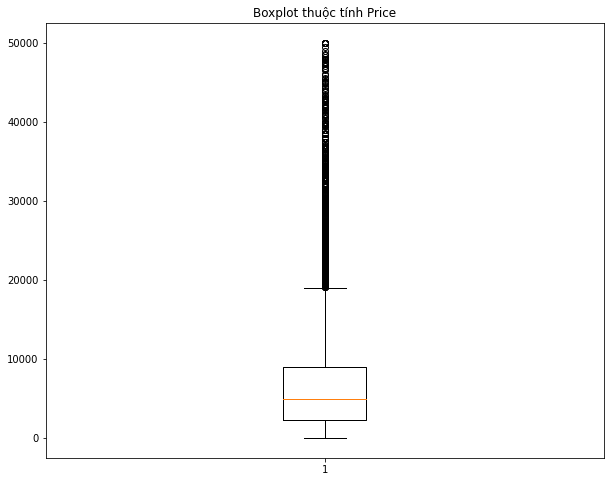

In [24]:
plt.figure(figsize=(10,8)) 
plt.boxplot(dataY['price'])
plt.title('Boxplot thuộc tính Price')
plt.show()

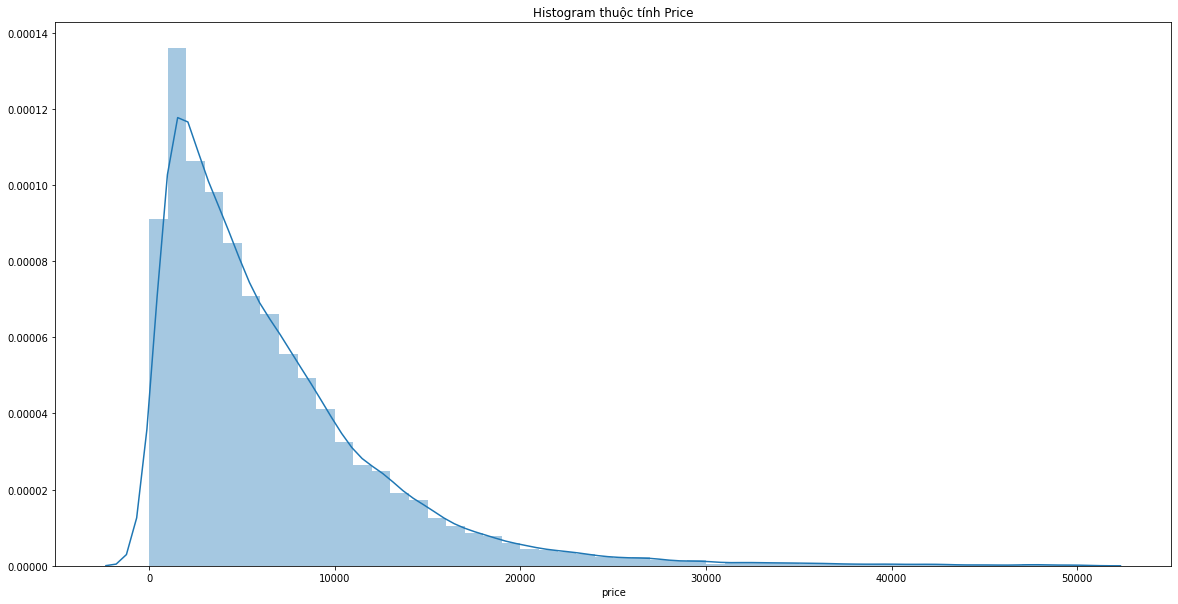

In [25]:
plt.figure(figsize=(20,10)) 
sns.distplot(dataY['price'])
plt.title('Histogram thuộc tính Price')
plt.show()

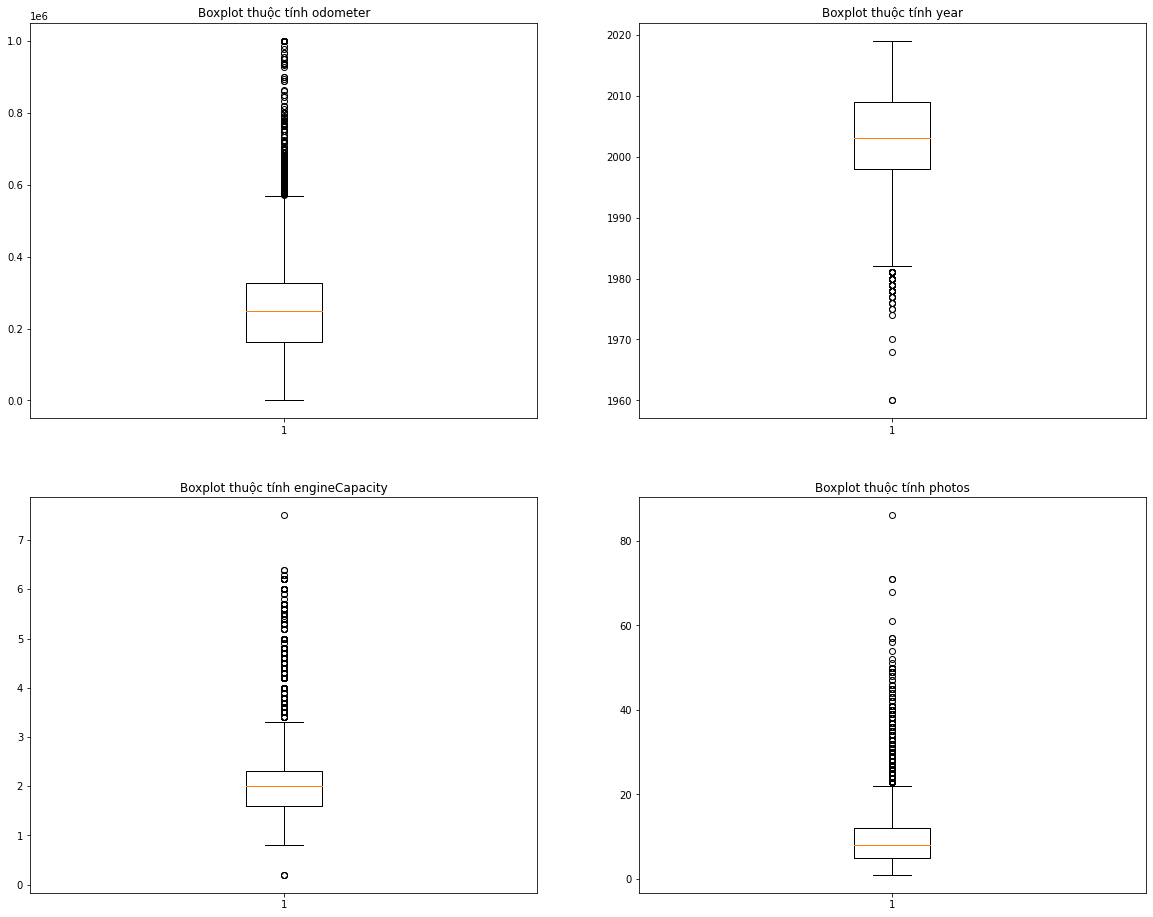

In [26]:
plt.figure(figsize=(20,16))
for i, col in enumerate(['odometer', 'year', 'engineCapacity', 'photos']):
    plt.subplot(2, 2, i + 1)
    plt.boxplot(dataX[col])
    plt.title('Boxplot thuộc tính ' + col)

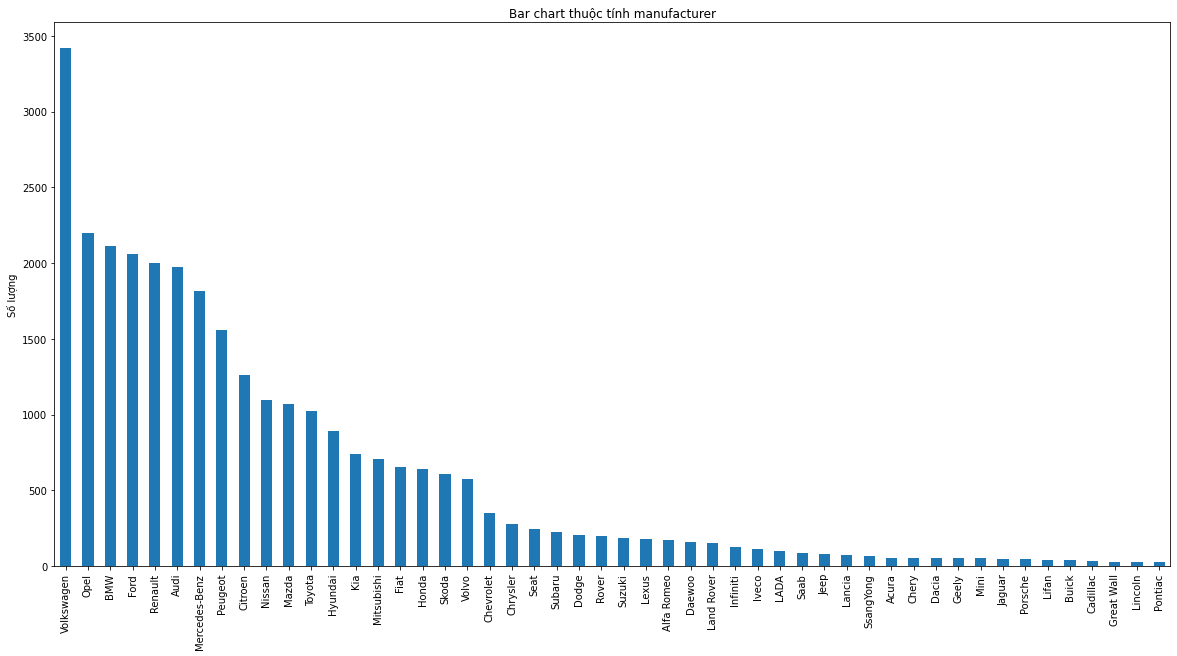

In [27]:
plt.figure(figsize=(20,10)) 
dataX['manufacturer'].value_counts().plot.bar()
plt.title('Bar chart thuộc tính manufacturer')
plt.ylabel('Số lượng')
plt.show()

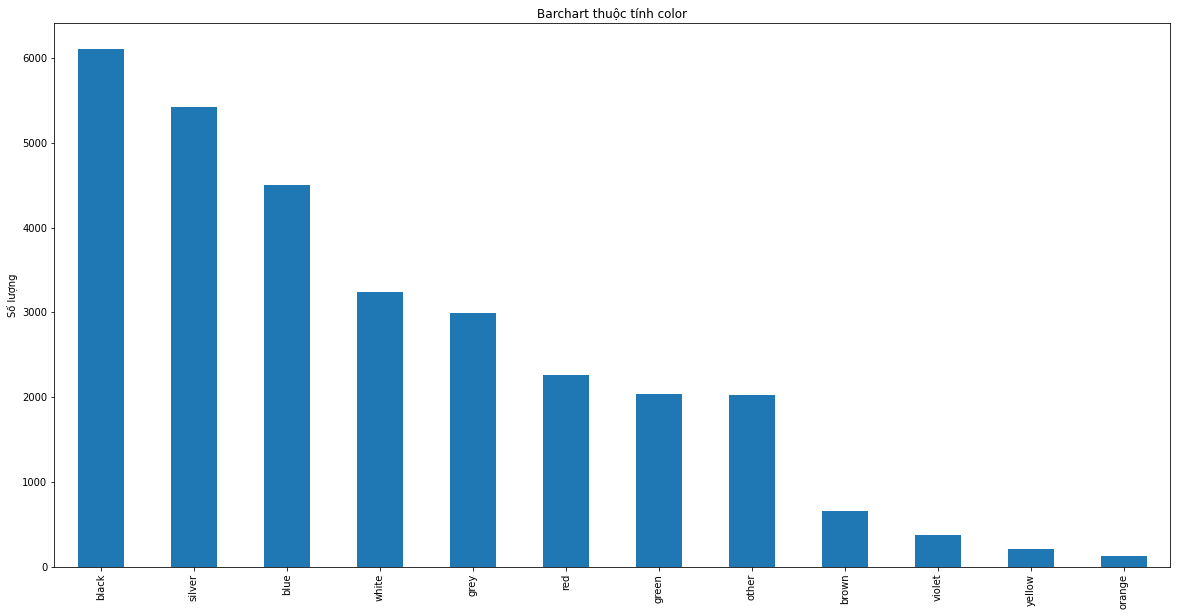

In [28]:
plt.figure(figsize=(20,10)) 
dataX['color'].value_counts().plot.bar()
plt.title('Barchart thuộc tính color')
plt.ylabel('Số lượng')
plt.show()

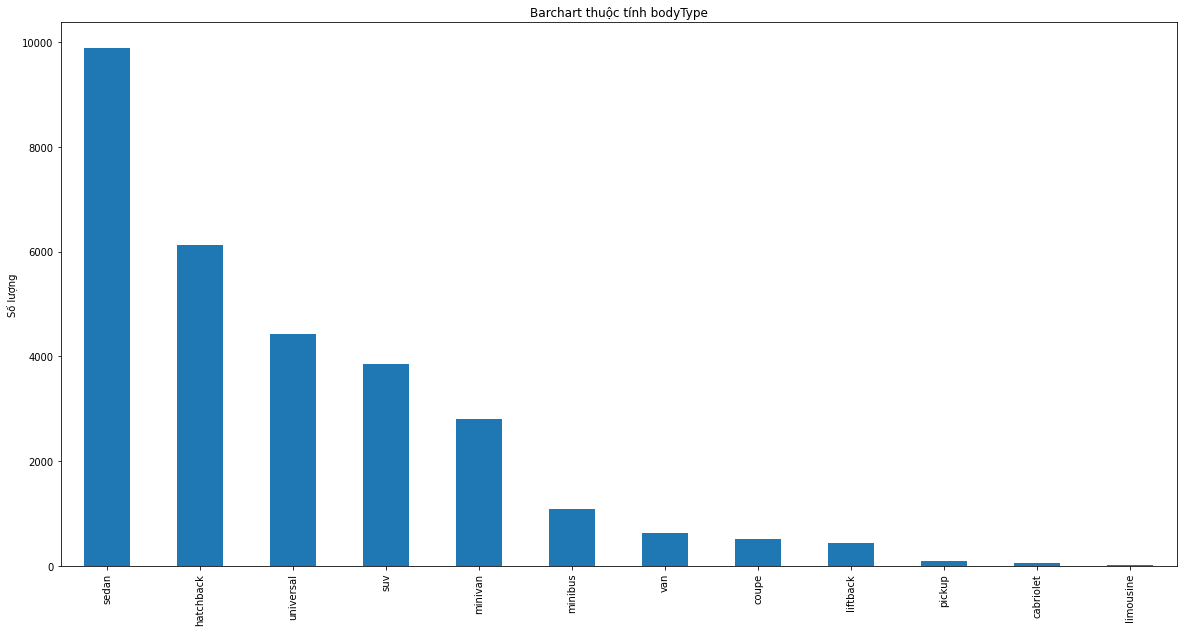

In [29]:
plt.figure(figsize=(20,10)) 
dataX['bodyType'].value_counts().plot.bar()
plt.title('Barchart thuộc tính bodyType')
plt.ylabel('Số lượng')
plt.show()

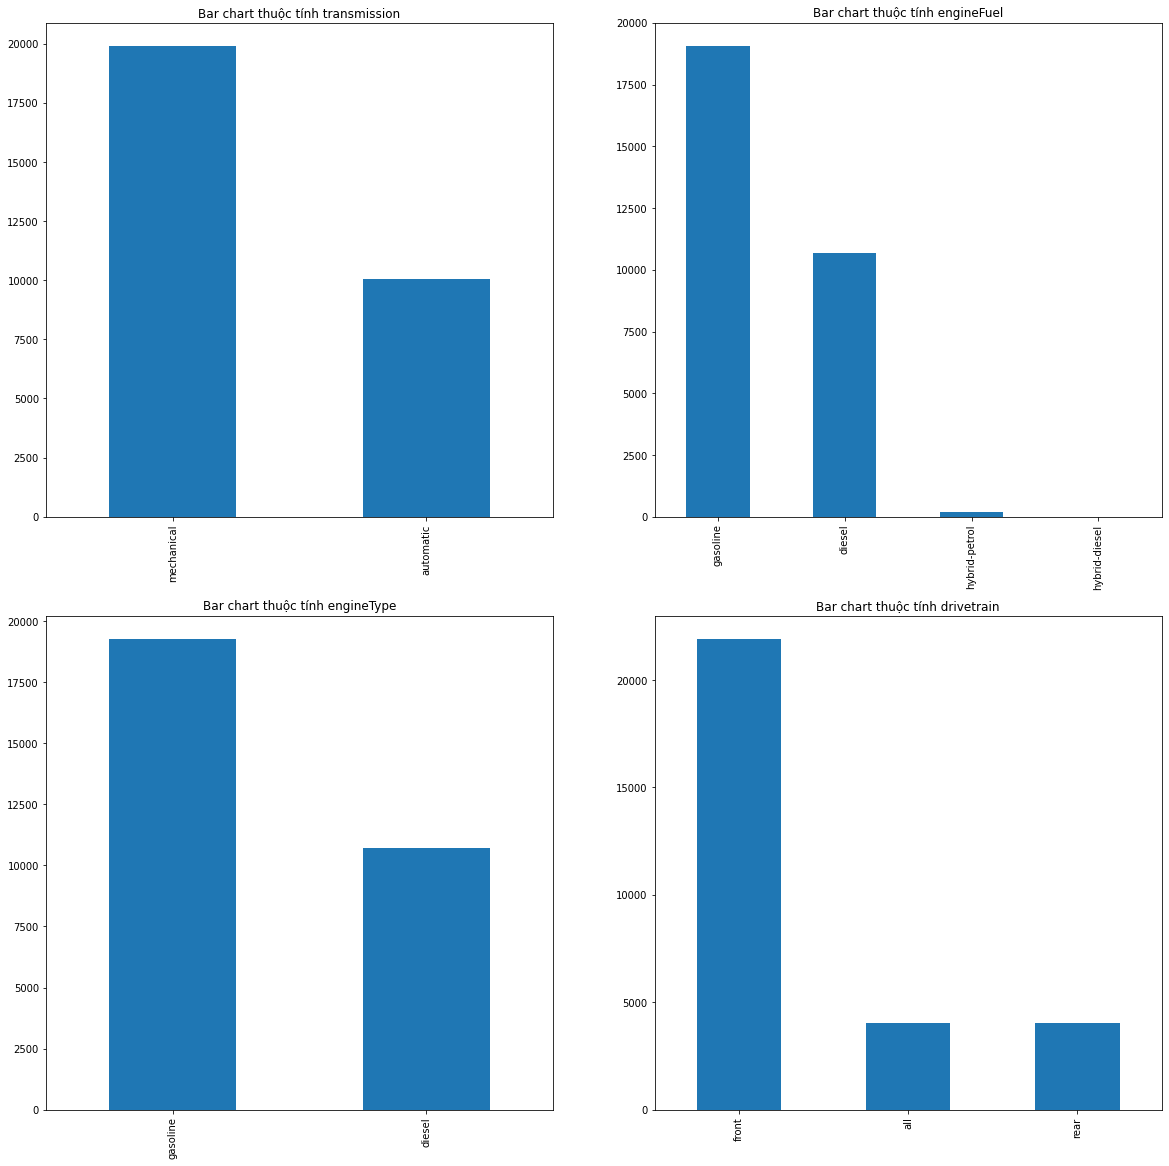

In [30]:
plt.figure(figsize=(20,20))
for i, col in enumerate(['transmission', 'engineFuel', 'engineType', 'drivetrain']):
    plt.subplot(2, 2, i + 1)
    dataX[col].value_counts().plot.bar()
    plt.title('Bar chart thuộc tính ' + col)

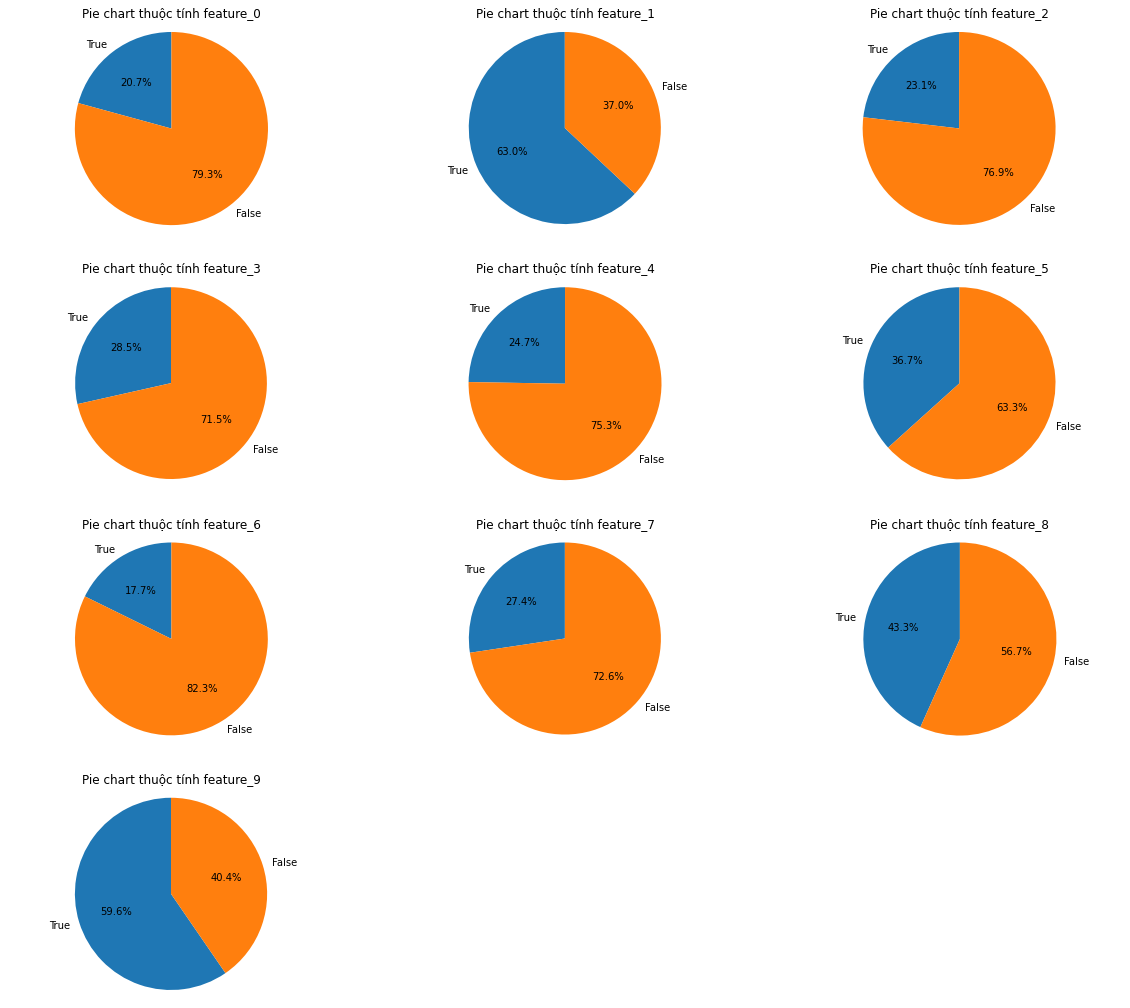

In [31]:
plt.figure(figsize=(20,18))
for i in range(10):
    col = data['feature_' + str(i)]
    plt.subplot(4, 3, i + 1)
    plt.pie([np.sum(col), len(col) - np.sum(col)], labels=['True', 'False'], autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Pie chart thuộc tính feature_' + str(i))

### 2. Trực quan mối quan hệ giữa các thuộc tính

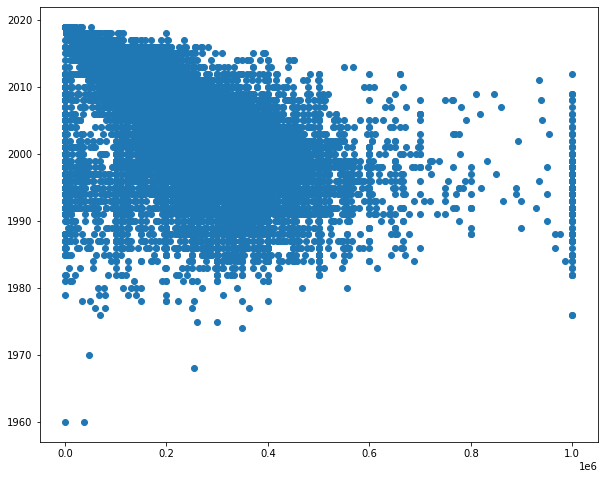

In [32]:
plt.figure(figsize=(10,8)) 
plt.scatter(dataX['odometer'], dataX['year'])
plt.show()

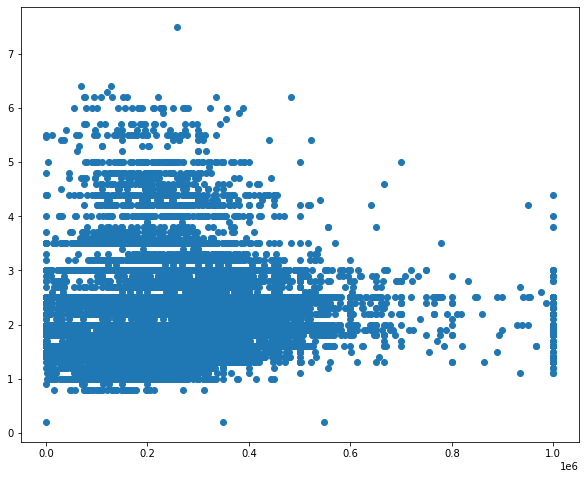

In [33]:
plt.figure(figsize=(10,8)) 
plt.scatter(dataX['odometer'], dataX['engineCapacity'])
plt.show()

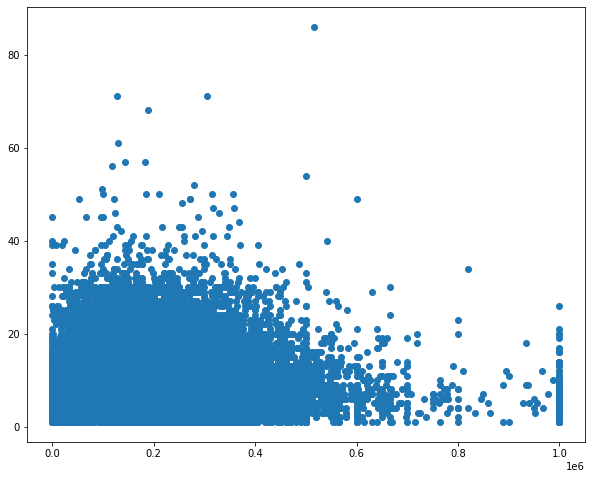

In [34]:
plt.figure(figsize=(10,8))  
plt.scatter(dataX['odometer'], dataX['photos'])
plt.show()

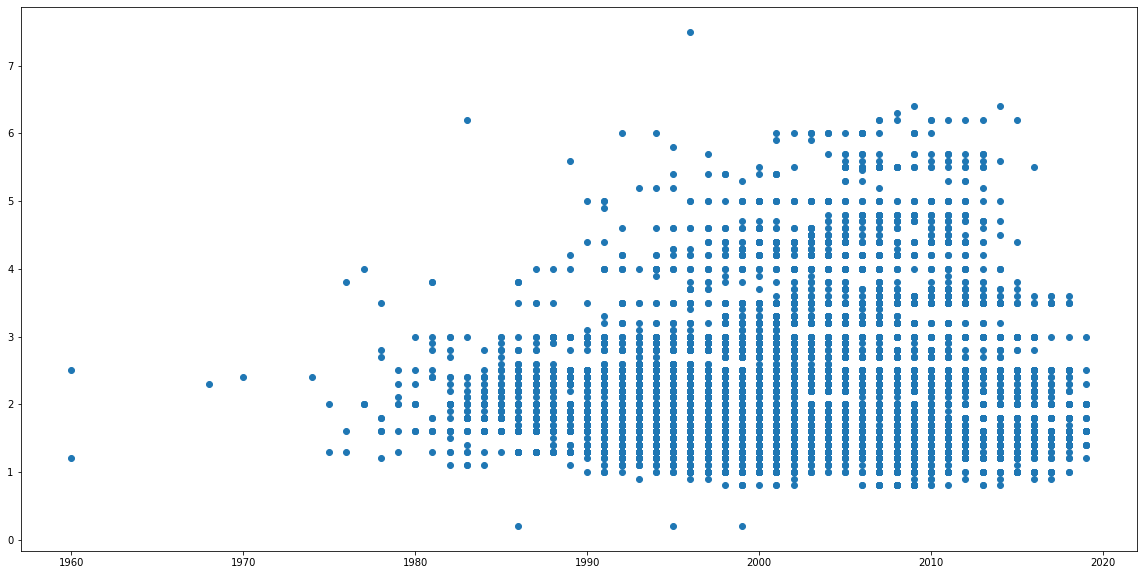

In [35]:
plt.figure(figsize=(20,10)) 
plt.scatter(dataX['year'], dataX['engineCapacity'])
plt.show()

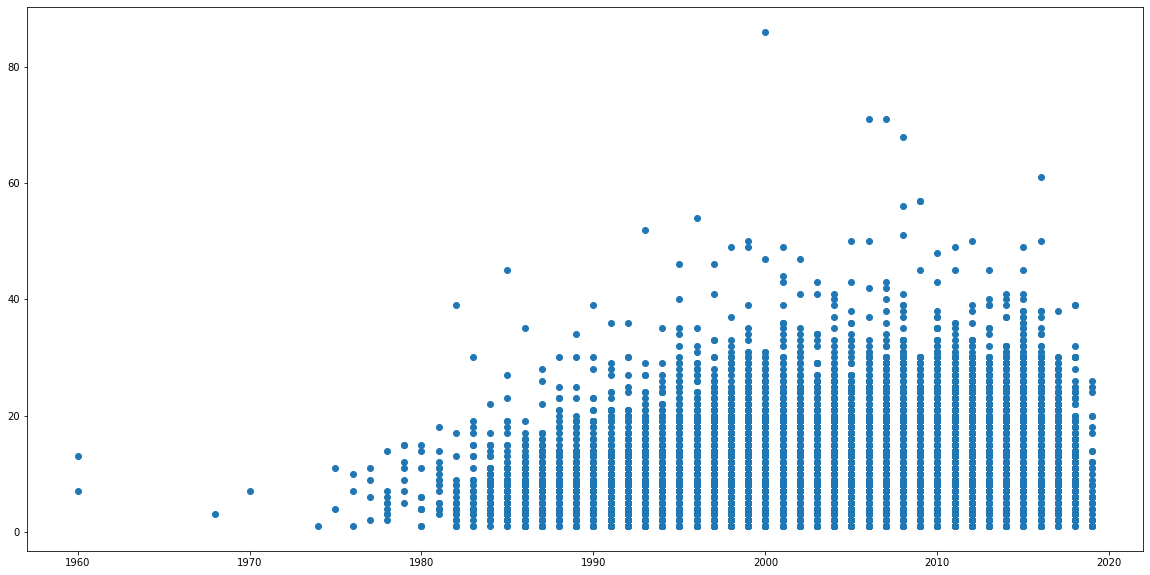

In [36]:
plt.figure(figsize=(20,10)) 
plt.scatter(dataX['year'], dataX['photos'])
plt.show()

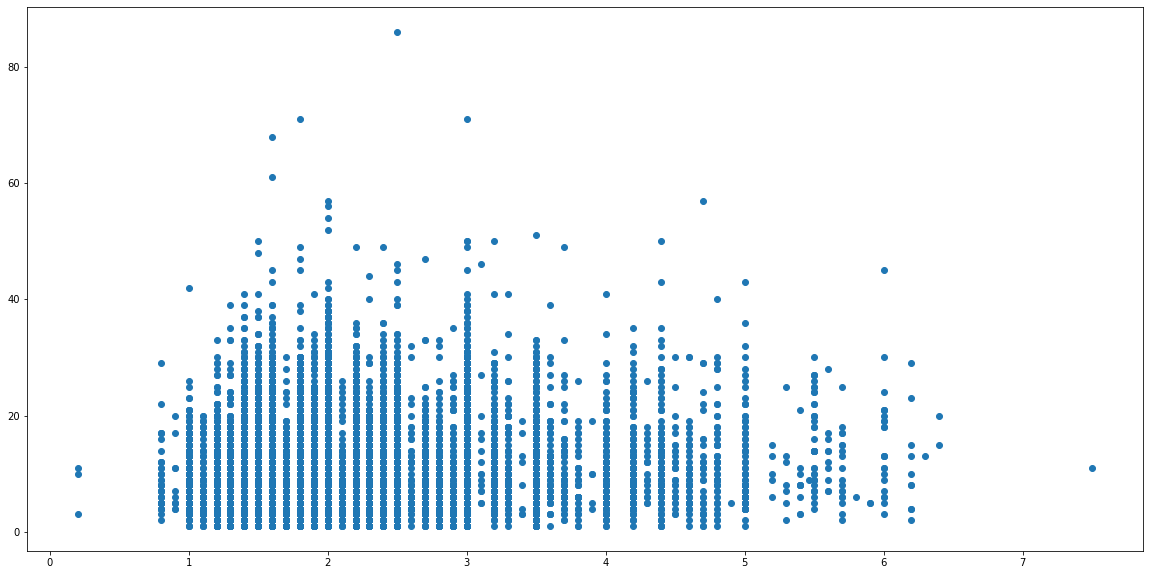

In [37]:
plt.figure(figsize=(20,10)) 
plt.scatter(dataX['engineCapacity'], dataX['photos'])
plt.show()

Scatter plot giữa price và các thuộc tính


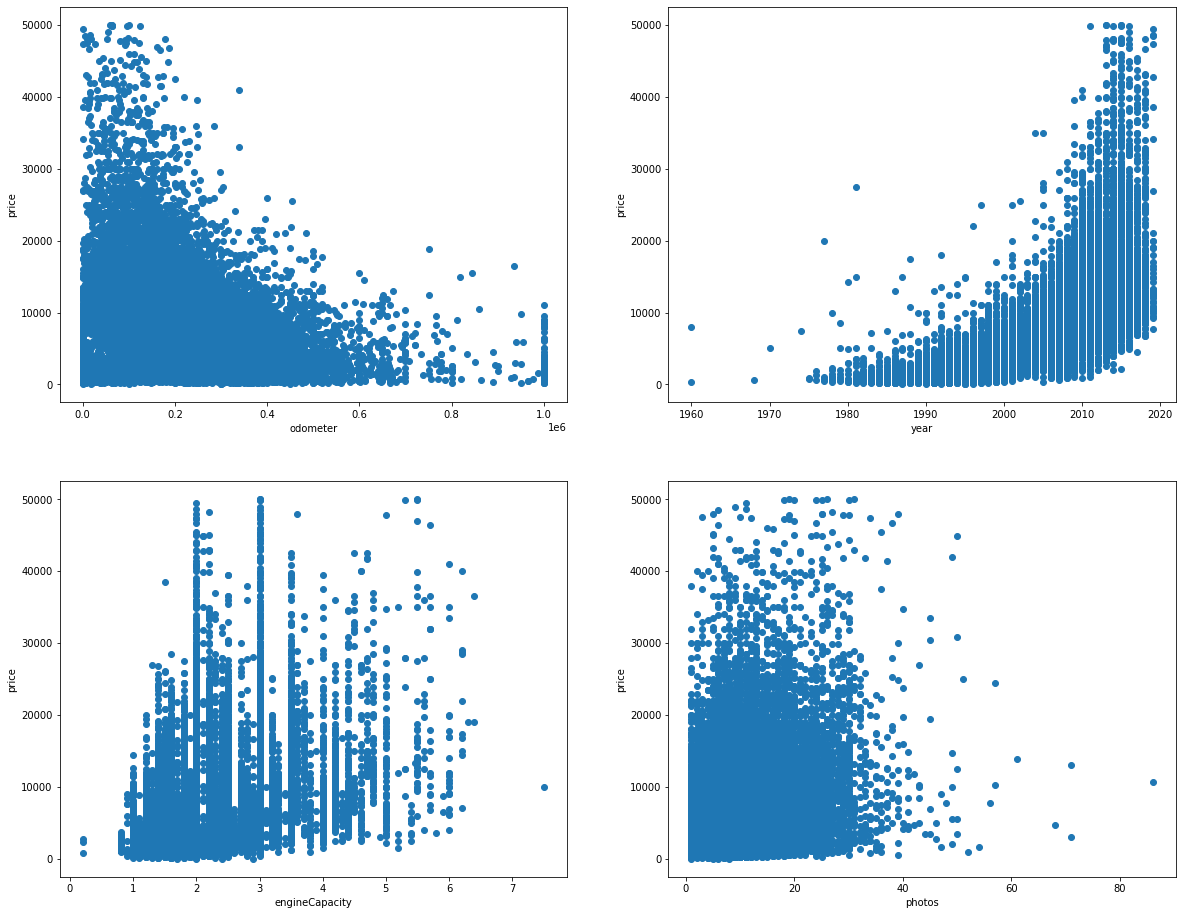

In [38]:
plt.figure(figsize=(20,16))
for i, col in enumerate(['odometer', 'year', 'engineCapacity', 'photos']):
    plt.subplot(2, 2, i + 1)
    plt.scatter(dataX[col], dataY['price'])
    plt.xlabel(col)
    plt.ylabel('price')
print('Scatter plot giữa price và các thuộc tính')

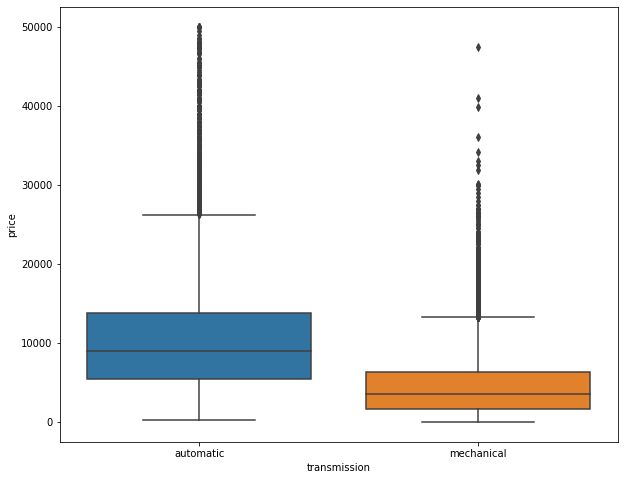

In [39]:
plt.figure(figsize = (10,8))
sns.boxplot(x = 'transmission', y = 'price', data = data)
plt.show()

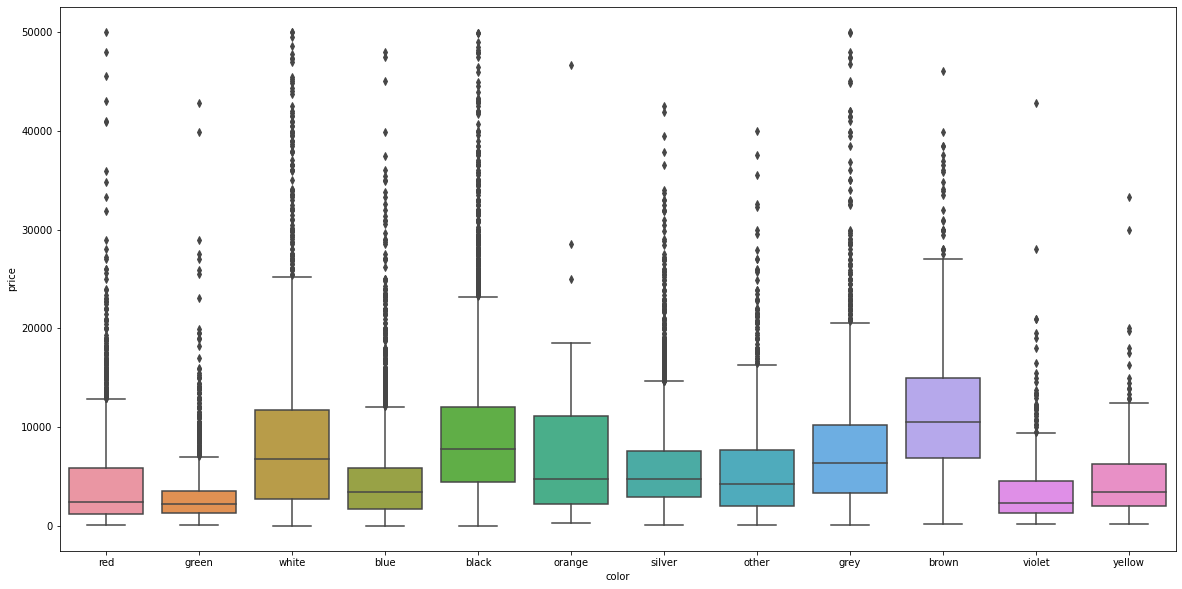

In [40]:
plt.figure(figsize = (20,10))
sns.boxplot(x = 'color', y = 'price', data = data)
plt.show()

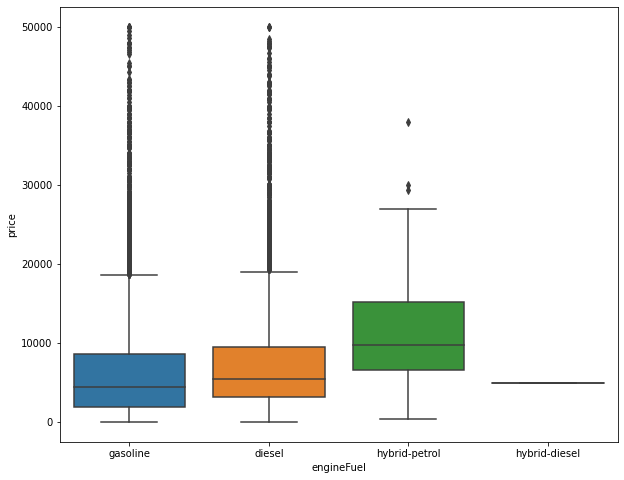

In [41]:
plt.figure(figsize = (10,8))
sns.boxplot(x = 'engineFuel', y = 'price', data = data)
plt.show()

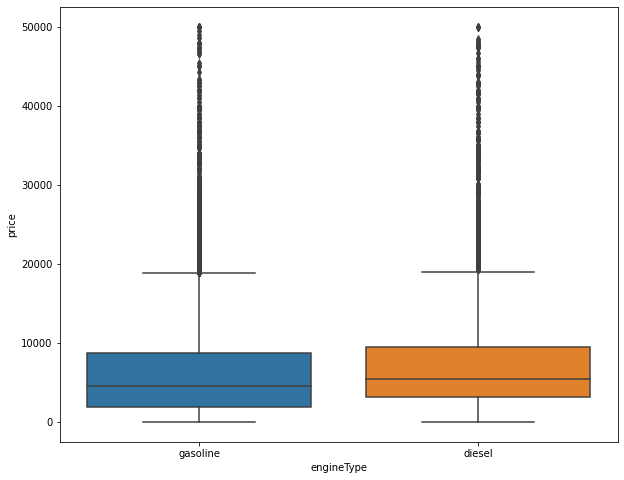

In [42]:
plt.figure(figsize = (10,8))
sns.boxplot(x = 'engineType', y = 'price', data = data)
plt.show()

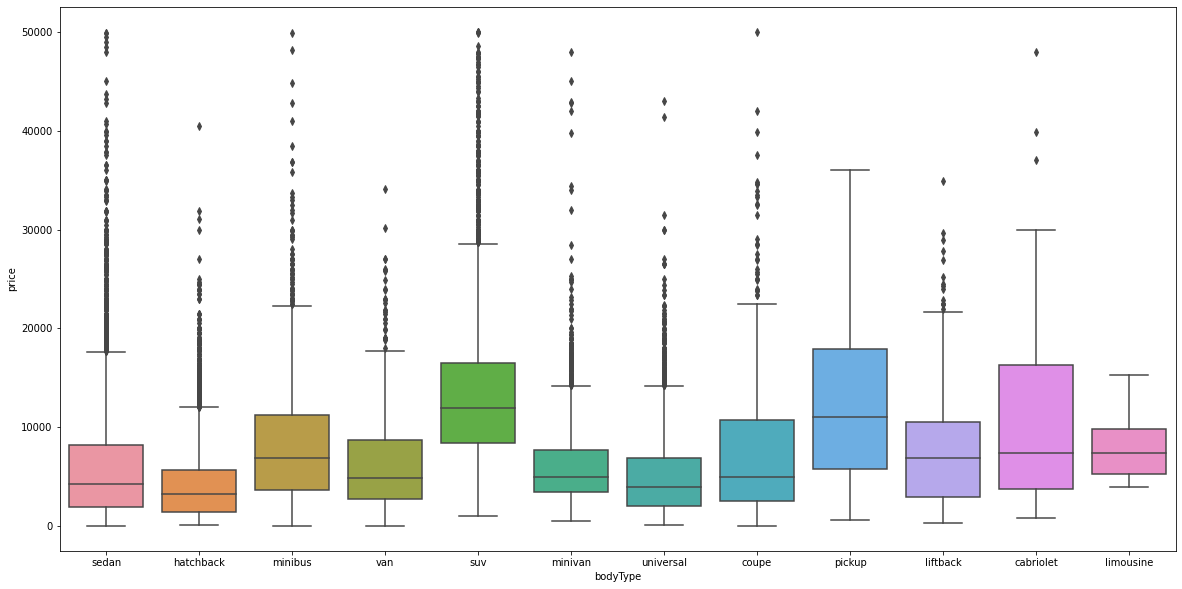

In [43]:
plt.figure(figsize = (20,10))
sns.boxplot(x = 'bodyType', y = 'price', data = data)
plt.show()

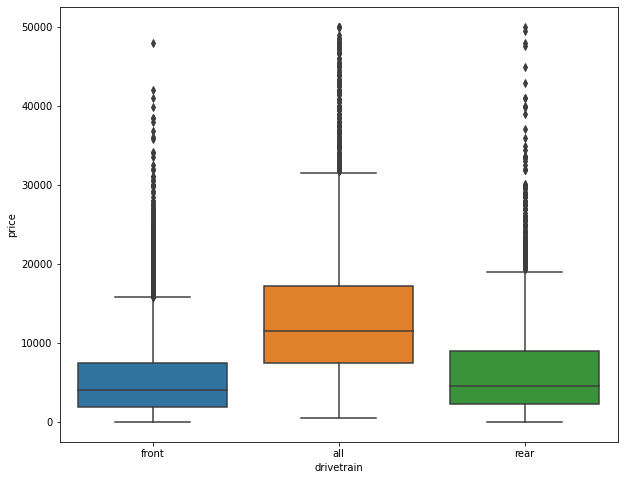

In [44]:
plt.figure(figsize = (10,8))
sns.boxplot(x = 'drivetrain', y = 'price', data = data)
plt.show()

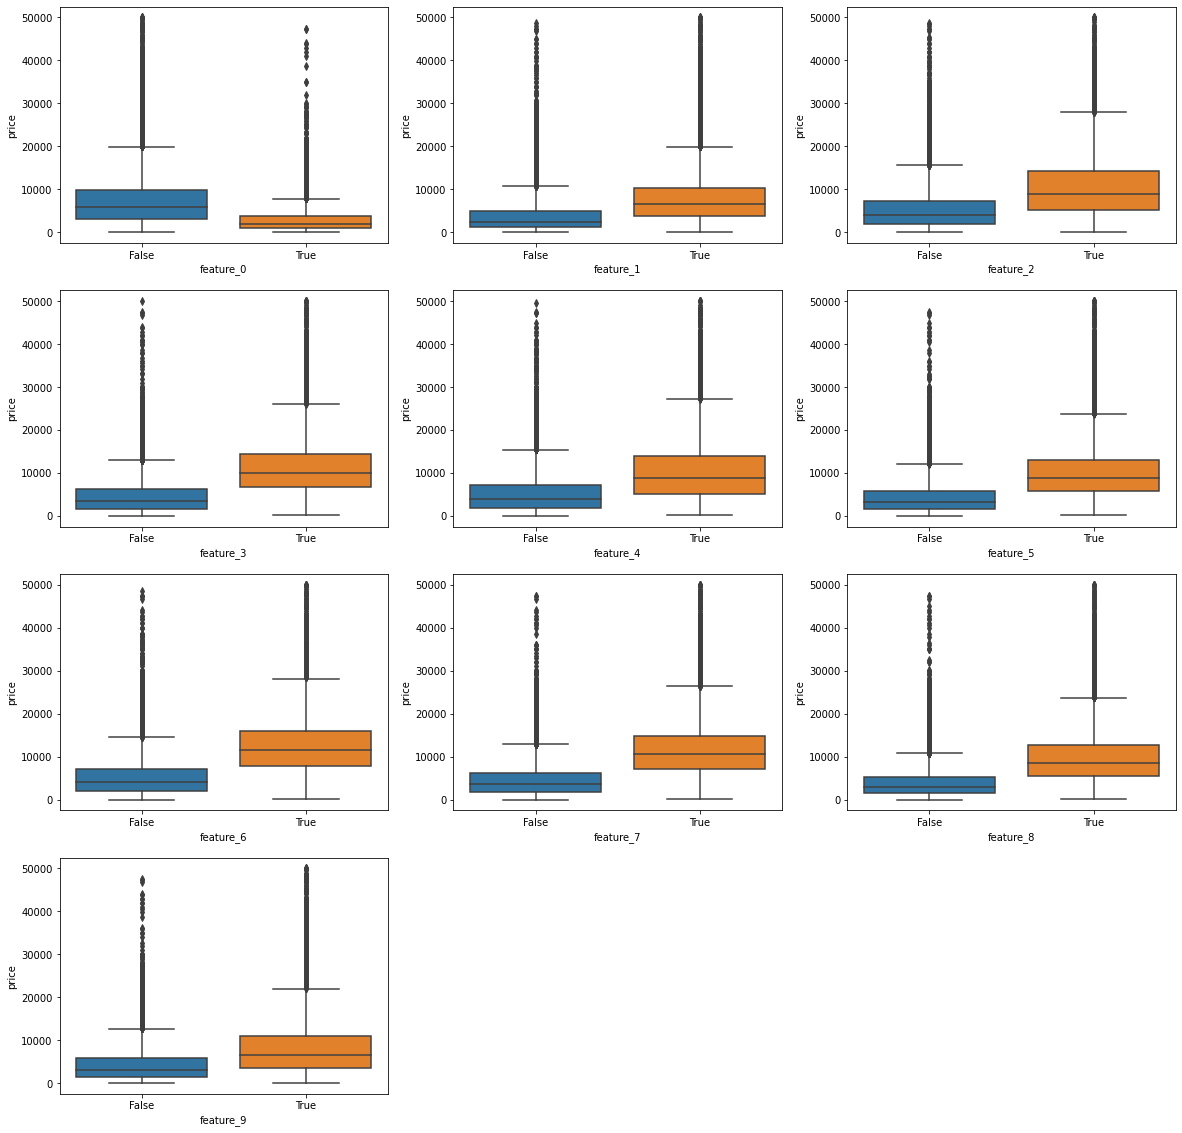

In [45]:
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(x = 'feature_' + str(i), y = 'price', data = data)

## V. LỰA CHỌN THUỘC TÍNH (FEATURES SELECTION)

### 1. Đo độ tương quan của các numeric feature

- Thang đo từ -1 đến 1, độ lớn biểu hiện cho mức độ tương quan, dấu dương thể hiện sự đồng biến, dấu âm thể hiện sự nghịch biến.

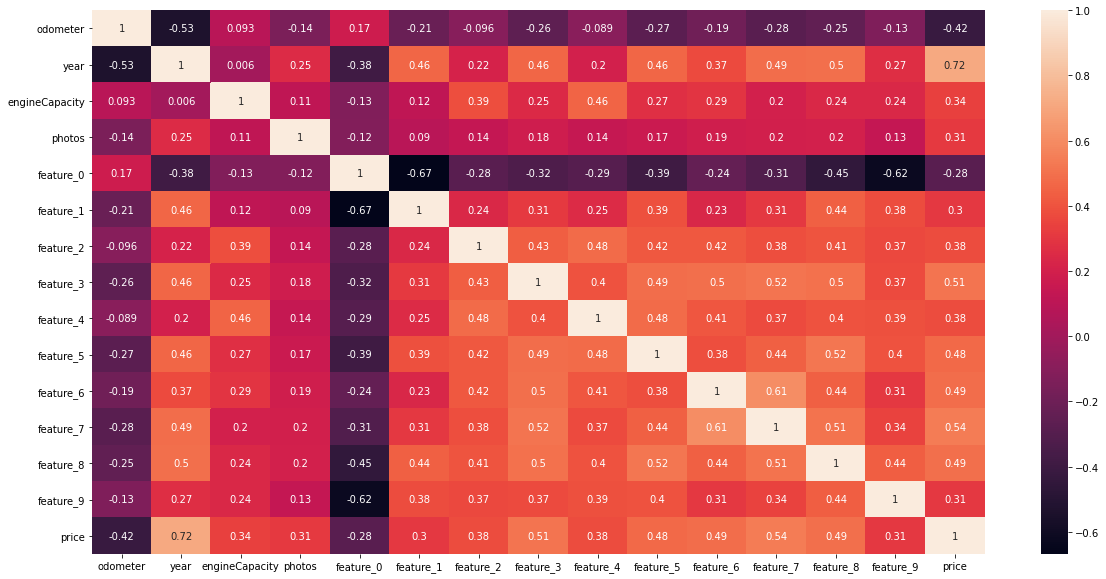

In [46]:
plt.figure(figsize=(20,10)) 
sns.heatmap(data.corr(), annot = True)
plt.show()

- Thuộc tính year và price có độ tương quan khá cao, hợp lý với biểu đồ scatter plot của 2 thuộc tính này

### 2. Đo độ tương quan của các categorical feature

- Thang đo từ 0 đến 1, giá trị càng lớn thể hiện sự phụ thuộc càng cao

In [47]:
def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

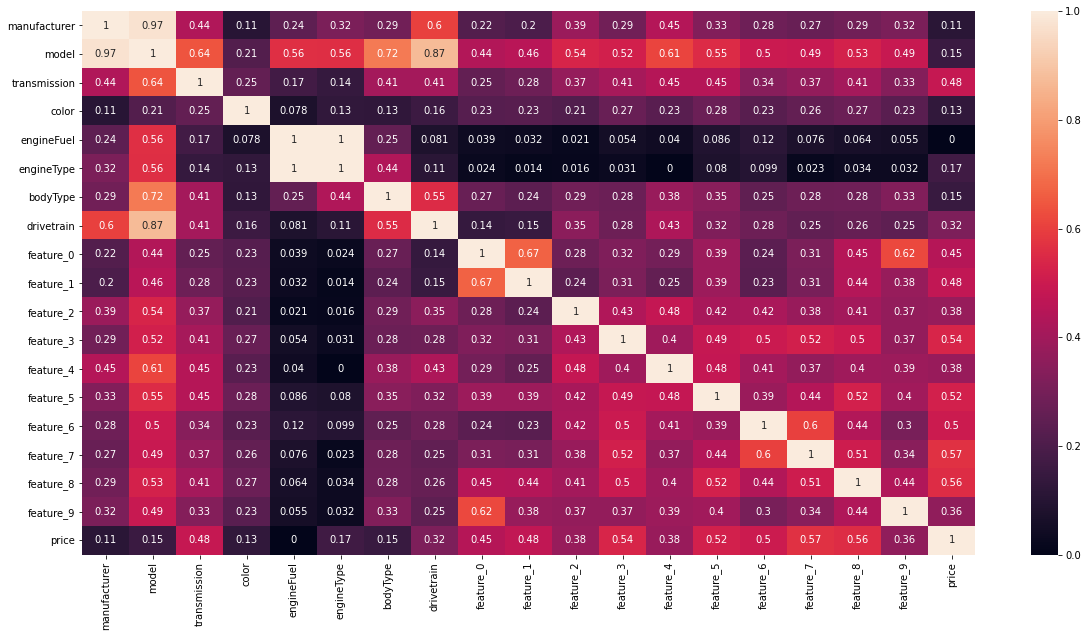

In [48]:
categoricalFeature = [ 'manufacturer', 'model', 'transmission', 'color', 
                       'engineFuel', 'engineType', 'bodyType', 'drivetrain',
                       'feature_0', 'feature_1', 'feature_2', 'feature_3',
                       'feature_4', 'feature_5', 'feature_6', 'feature_7', 
                       'feature_8', 'feature_9', 'price']
length = len(categoricalFeature)
res = [ [ 0 for i in range(length) ] for j in range(length) ] 
for i in range(0, length):
    for j in range(0, length):
        confusion_matrix = pd.crosstab(data[categoricalFeature[i]], data[categoricalFeature[j]])
        correlationCal = cramers_v(confusion_matrix.values)
        res[i][j] = round(correlationCal,3)
        #if (correlationCal >= 0.9 and correlationCal < 1):
        #    print(categoricalFeature[i] + '-' + categoricalFeature[j] + ':' + str(correlationCal))
res = pd.DataFrame(res, index=categoricalFeature, columns=categoricalFeature)
plt.figure(figsize=(20,10)) 
sns.heatmap(res, annot = True)
plt.show()

- Có các mối quan hệ giữa model và manufacturer; engineFuel và engineType 
    - Quan sát dữ liệu thấy model được quyết định bởi manufacturer, hơn nữa model là thuộc tính category có gần 1000 giá trị khác nhau nên loại bỏ nó khỏi dữ liệu
    - engineFuel cũng được quyết định bởi engineType nên bị loại bỏ

In [49]:
# Features selected: ['manufacturer', 'transmission', 'color', 'odometer', 'year,
#       'engineType', 'engineCapacity', 'bodyType', 'drivetrain',
#       'photos', 'feature_0', 'feature_1', 'feature_2', 'feature_3',
#       'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8',
#       'feature_9']
# Features eliminated: ['model', 'engineFuel'] 
dataX.drop(columns=['model', 'engineFuel'], axis=1, inplace=True, errors='ignore')
dataX.shape

(29949, 20)

## VI. CHUẨN HOÁ DỮ LIỆU (NORMALIZE DATA)

- Chuẩn hoá các dữ liệu số sao cho từng cột có trung bình μ=0 và độ lệch chuẩn σ=1 với:

$$\mu = \frac{1}{N}\displaystyle\sum_{i=1}^{N} x_i$$
$$\sigma = \sqrt{\frac{1}{N}\displaystyle\sum_{i=1}^{N} (x_i-\mu)^2}$$
$$z = \frac{x - \mu}{\sigma}$$


In [50]:
# Get column names
numericFeatures = ['odometer','year','engineCapacity','photos']
# Create the Scaler object
scaler = preprocessing.StandardScaler()

# Standardize dataX
# Fit data on the scaler object
scaled_df = scaler.fit_transform(dataX[numericFeatures])
scaled_df = pd.DataFrame(scaled_df, index=dataX[numericFeatures].index, columns=numericFeatures)
# Update dataX 
dataX.update(scaled_df)

# Standardize data
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(data[numericFeatures])
scaled_df = pd.DataFrame(scaled_df, index=data[numericFeatures].index, columns=numericFeatures)
# Update dataX 
data.update(scaled_df)
data[numericFeatures]

,odometer,year,engineCapacity,photos
0,-1.559269,1.446670,-0.081713,-1.419866
1,0.510816,-0.416370,-0.232640,0.537986
2,-0.676439,1.047448,-0.081713,0.701140
3,1.010619,-0.682518,0.672921,-1.419866
4,-0.283336,0.249002,0.521994,0.374832
...,...,...,...,...
29995,-0.006706,0.648225,0.521994,-0.604094
29996,0.282497,-0.815593,-0.383566,-0.114631
29997,-0.021927,-1.347890,-0.081713,-0.440940
29998,0.107454,-0.150221,-0.534493,-0.604094


## VII. Handle Categorical Features

In [51]:
dataX = pd.get_dummies(dataX[dataX.keys()], drop_first = True)
print(len(dataX.keys()))
print(dataX.keys())
dataX

89
Index(['odometer', 'year', 'engineCapacity', 'photos', 'feature_0',
       'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'manufacturer_Alfa Romeo', 'manufacturer_Audi', 'manufacturer_BMW',
       'manufacturer_Buick', 'manufacturer_Cadillac', 'manufacturer_Chery',
       'manufacturer_Chevrolet', 'manufacturer_Chrysler',
       'manufacturer_Citroen', 'manufacturer_Dacia', 'manufacturer_Daewoo',
       'manufacturer_Dodge', 'manufacturer_Fiat', 'manufacturer_Ford',
       'manufacturer_Geely', 'manufacturer_Great Wall', 'manufacturer_Honda',
       'manufacturer_Hyundai', 'manufacturer_Infiniti', 'manufacturer_Iveco',
       'manufacturer_Jaguar', 'manufacturer_Jeep', 'manufacturer_Kia',
       'manufacturer_LADA', 'manufacturer_Lancia', 'manufacturer_Land Rover',
       'manufacturer_Lexus', 'manufacturer_Lifan', 'manufacturer_Lincoln',
       'manufacturer_Mazda', 'manufacturer_Mercedes-Benz', 'ma

,odometer,year,engineCapacity,photos,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,...,bodyType_limousine,bodyType_minibus,bodyType_minivan,bodyType_pickup,bodyType_sedan,bodyType_suv,bodyType_universal,bodyType_van,drivetrain_front,drivetrain_rear
0,-1.559269,1.446670,-0.081713,-1.419866,False,True,False,False,False,True,...,0,0,0,0,1,0,0,0,1,0
1,0.510816,-0.416370,-0.232640,0.537986,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,1,0
2,-0.676439,1.047448,-0.081713,0.701140,False,True,False,True,False,False,...,0,1,0,0,0,0,0,0,1,0
3,1.010619,-0.682518,0.672921,-1.419866,False,True,True,False,False,False,...,0,1,0,0,0,0,0,0,1,0
4,-0.283336,0.249002,0.521994,0.374832,False,False,False,False,False,False,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,-0.006706,0.648225,0.521994,-0.604094,False,True,True,False,True,True,...,0,0,0,0,1,0,0,0,1,0
29996,0.282497,-0.815593,-0.383566,-0.114631,True,False,False,False,False,False,...,0,0,0,0,1,0,0,0,1,0
29997,-0.021927,-1.347890,-0.081713,-0.440940,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,1,0
29998,0.107454,-0.150221,-0.534493,-0.604094,False,True,False,False,False,False,...,0,0,0,0,0,0,1,0,1,0


## VIII. LỰA CHỌN MÔ HÌNH (MODEL SELECTION)

### 1. Xây dựng baseline model

In [52]:
# Features selecion: drop 'model'
del baselineX['model']

# Drop NaN records
NaNRows = baselineX[baselineX.isna().any(axis=1)]
baselineX.drop(index=NaNRows.index, errors='ignore', inplace=True)
baselineY.drop(index=NaNRows.index, errors='ignore', inplace=True)
print(len(baselineX.index))
print(len(baselineY.index))

# Dummy categorical features
baselineX = pd.get_dummies(baselineX[baselineX.keys()], drop_first = True)
print(len(baselineX.keys()))
print(baselineX.keys())

29991
29991
92
Index(['odometer', 'year', 'engineCapacity', 'photos', 'feature_0',
       'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'manufacturer_Alfa Romeo', 'manufacturer_Audi', 'manufacturer_BMW',
       'manufacturer_Buick', 'manufacturer_Cadillac', 'manufacturer_Chery',
       'manufacturer_Chevrolet', 'manufacturer_Chrysler',
       'manufacturer_Citroen', 'manufacturer_Dacia', 'manufacturer_Daewoo',
       'manufacturer_Dodge', 'manufacturer_Fiat', 'manufacturer_Ford',
       'manufacturer_Geely', 'manufacturer_Great Wall', 'manufacturer_Honda',
       'manufacturer_Hyundai', 'manufacturer_Infiniti', 'manufacturer_Iveco',
       'manufacturer_Jaguar', 'manufacturer_Jeep', 'manufacturer_Kia',
       'manufacturer_LADA', 'manufacturer_Lancia', 'manufacturer_Land Rover',
       'manufacturer_Lexus', 'manufacturer_Lifan', 'manufacturer_Lincoln',
       'manufacturer_Mazda', 'manufacturer_Mercede

In [53]:
# Ordinary Least Squared
kf = KFold(n_splits = 10, shuffle = True)
n = kf.get_n_splits(baselineX)
avg_rmse = 0.0
for train_index, test_index in kf.split(baselineX):
    x_train = baselineX.iloc[train_index]
    x_test = baselineX.iloc[test_index]
    y_train = baselineY.iloc[train_index]
    y_test = baselineY.iloc[test_index]
    regressor = linear_model.LinearRegression(n_jobs=20)
    model = regressor.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print(rmse)
    avg_rmse += rmse/n
print('Average RMSE: ', avg_rmse)

2945.419964179182
3143.2490352188556
2959.9708152506264
2992.196441576573
2958.554415724463
3093.8585397639167
2939.9129572589713
2859.2423900409212
3076.3442674144885
3095.01334302421
Average RMSE:  3006.376216945221


### 2. Ordinary Least Square

In [54]:
# Ordinary Least Squares
kf = KFold(n_splits = 10, shuffle = True)
n = kf.get_n_splits(dataX)
avg_rmse = 0.0
for train_index, test_index in kf.split(dataX):
    x_train = dataX.iloc[train_index]
    x_test = dataX.iloc[test_index]
    y_train = dataY.iloc[train_index]
    y_test = dataY.iloc[test_index]
    #
    regressor = linear_model.LinearRegression(n_jobs=20)
    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    #
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print(rmse)
    avg_rmse += rmse / n
print('Average RMSE: ', avg_rmse)

2968.3169192340506
2937.608905228427
2898.3824048327956
2940.7484171239225
2987.266473172656
3021.8917853136777
3110.2385833659623
3227.387273515915
3009.3365725783237
2972.567157195348
Average RMSE:  3007.374449156108


### 3. Polynomical GAM Model

In [55]:
# polynomial # GAM
kf = KFold(n_splits = 10, shuffle = True)
n = kf.get_n_splits(dataX)
avg_rmse = 0.0
for train_index, test_index in kf.split(dataX):
    x_train = dataX.iloc[train_index]
    x_test = dataX.iloc[test_index]
    y_train = dataY.iloc[train_index]
    y_test = dataY.iloc[test_index]
    #
    gam = LinearGAM(s(0, n_splines=12) + s(1, n_splines=12) + s(2, n_splines=12) + s(3, n_splines=12) + l(4) + l(5) + l(6) + l(7) + l(8) + l(9) + 
                    l(10) + l(11) + l(12) + l(13) + l(14) + l(15) + l(16) + l(17) + l(18) + l(19) +
                    l(20) + l(21) + l(22) + l(23) + l(24) + l(25) + l(26) + l(27) + l(28) + l(29) + 
                    l(30) + l(31) + l(32) + l(33) + l(34) + l(35) + l(36) + l(37) + l(38) + l(39) + 
                    l(40) + l(41) + l(42) + l(43) + l(44) + l(45) + l(46) + l(47) + l(48) + l(49) + 
                    l(50) + l(51) + l(52) + l(53) + l(54) + l(55) + l(56) + l(57) + l(58) + l(59) +
                    l(60) + l(61) + l(62) + l(63) + l(64) + l(65) + l(66) + l(67) + l(68) + l(69) +
                    l(70) + l(71) + l(72) + l(73) + l(74) + l(75) + l(76) + l(77) + l(78) + l(79) +
                    l(80) + l(81) + l(82) + l(83) + l(84) + l(85) + l(86) + l(87) + l(88)).fit(x_train,y_train)
    y_pred = gam.predict(x_test)
    #
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print(rmse)
    avg_rmse += rmse / n
print('Average RMSE: ', avg_rmse)

2461.636742499315
2594.730727368533
2657.3995197440186
2786.0496399204994
2701.9059681516273
2448.159045519287
2700.61604533085
2563.5550220853734
2529.7924051458413
2631.7619318308384
Average RMSE:  2607.560704759618


### 4. Extreme Boost Regression

In [56]:
# Extreme Boosting Regression
kf = KFold(n_splits = 10, shuffle = True)
n = kf.get_n_splits(dataX)
avg_rmse = 0.0
for train_index, test_index in kf.split(dataX):
    x_train = dataX.iloc[train_index]
    x_test = dataX.iloc[test_index]
    y_train = dataY.iloc[train_index]
    y_test = dataY.iloc[test_index]
    #
    xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=8, objective='reg:squarederror')
    model = xgb.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    #
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print(rmse)
    avg_rmse += rmse / n
print('Average RMSE: ', avg_rmse)

1878.6575730597688
1693.0978130414612
1650.9100825333167
1816.4835750646748
1718.4945037169764
1755.2710266526738
1729.7525805614596
1939.8500368930747
1640.8160234705178
1838.018880556821
Average RMSE:  1766.1352095550747


## IX. Evaluation

In [57]:
"""
def preprocessing(X, Y):
    return 0
def train(X_train, Y_train):
    preprocessing(X_train, Y_train)
    return 0
def test(X_test, Y_test):
    preprocessing(X_test, Y_test)
    rmse = 0
    return rmse;

train(dataX, dataY)
test(X_test, Y_test)
"""

'\ndef preprocessing(X, Y):\n    return 0\ndef train(X_train, Y_train):\n    preprocessing(X_train, Y_train)\n    return 0\ndef test(X_test, Y_test):\n    preprocessing(X_test, Y_test)\n    rmse = 0\n    return rmse;\n\ntrain(dataX, dataY)\ntest(X_test, Y_test)\n'

In [58]:
dummy = ['odometer', 'year', 'engineCapacity', 'photos', 'feature_0',
       'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'manufacturer_Alfa Romeo', 'manufacturer_Audi', 'manufacturer_BMW',
       'manufacturer_Buick', 'manufacturer_Cadillac', 'manufacturer_Chery',
       'manufacturer_Chevrolet', 'manufacturer_Chrysler',
       'manufacturer_Citroen', 'manufacturer_Dacia', 'manufacturer_Daewoo',
       'manufacturer_Dodge', 'manufacturer_Fiat', 'manufacturer_Ford',
       'manufacturer_Geely', 'manufacturer_Great Wall', 'manufacturer_Honda',
       'manufacturer_Hyundai', 'manufacturer_Infiniti', 'manufacturer_Iveco',
       'manufacturer_Jaguar', 'manufacturer_Jeep', 'manufacturer_Kia',
       'manufacturer_LADA', 'manufacturer_Lancia', 'manufacturer_Land Rover',
       'manufacturer_Lexus', 'manufacturer_Lifan', 'manufacturer_Lincoln',
       'manufacturer_Mazda', 'manufacturer_Mercedes-Benz', 'manufacturer_Mini',
       'manufacturer_Mitsubishi', 'manufacturer_Nissan', 'manufacturer_Opel',
       'manufacturer_Peugeot', 'manufacturer_Pontiac', 'manufacturer_Porsche',
       'manufacturer_Renault', 'manufacturer_Rover', 'manufacturer_Saab',
       'manufacturer_Seat', 'manufacturer_Skoda', 'manufacturer_SsangYong',
       'manufacturer_Subaru', 'manufacturer_Suzuki', 'manufacturer_Toyota',
       'manufacturer_Volkswagen', 'manufacturer_Volvo',
       'transmission_mechanical', 'color_blue', 'color_brown', 'color_green',
       'color_grey', 'color_orange', 'color_other', 'color_red',
       'color_silver', 'color_violet', 'color_white', 'color_yellow',
       'engineType_gasoline', 'bodyType_coupe', 'bodyType_hatchback',
       'bodyType_liftback', 'bodyType_limousine', 'bodyType_minibus',
       'bodyType_minivan', 'bodyType_pickup', 'bodyType_sedan', 'bodyType_suv',
       'bodyType_universal', 'bodyType_van', 'drivetrain_front',
       'drivetrain_rear']

In [59]:
def preprocessing(dataX, dataY):
    dataX.drop(['id'], axis=1, inplace=True, errors='ignore')
    dataY.drop(['id'], axis=1, inplace=True, errors='ignore')
    # Missing values
    NaNRows = dataX[dataX.isna().any(axis=1)]
    dataX.drop(index=NaNRows.index, errors='ignore', inplace=True)
    dataY.drop(index=NaNRows.index, errors='ignore', inplace=True)
    NaNRows = dataY[dataY.isna().any(axis=1)]
    dataX.drop(index=NaNRows.index, errors='ignore', inplace=True)
    dataY.drop(index=NaNRows.index, errors='ignore', inplace=True)
    # Features selection
    dataX.drop(columns=['model', 'engineFuel'], axis=1, inplace=True, errors='ignore')
    # Normalize data
    numericFeatures = ['odometer','year','engineCapacity','photos']
    ##scaler = preprocessing.StandardScaler()
    scaled_df = scaler.fit_transform(dataX[numericFeatures])
    scaled_df = pd.DataFrame(scaled_df, index=dataX[numericFeatures].index, columns=numericFeatures)
    dataX.update(scaled_df)
    # Dummy
    dataX = pd.get_dummies(dataX[dataX.keys()], drop_first = True)
    kept_columns = dummy
    deleted_columns = set(dataX.keys()) - set(kept_columns)
    dataX.drop(deleted_columns, axis=1, inplace=True, errors='ignore')
    return dataX, dataY

def train(X_train, Y_train):
    X_train, Y_train = preprocessing(X_train, Y_train)
    
    xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=8, objective='reg:squarederror')
    model = xgb.fit(X_train,Y_train)
    
    # save_model()
    with open("LinearModel", 'wb') as file:  
        pickle.dump(model, file)
    #
    return model
def test(X_test, Y_test):
    X_test, Y_test = preprocessing(X_test, Y_test)
    
    # load_model()
    with open("LinearModel", 'rb') as file:  
        model = pickle.load(file)
    #
    Y_pred = model.predict(X_test)
    rmse = np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))
    return rmse;

In [60]:
dataX = pd.read_csv("X_train.csv")
dataY = pd.read_csv("Y_train.csv")

In [61]:
train(dataX, dataY)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.75,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [62]:
test(dataX, dataY)

1262.248186331238